In [7]:
import numpy as np
import model.train_schedule
import model.model_defination
import model
from PIL import Image
import cv2
from matplotlib import pyplot as plt

In [4]:
net = model.model_defination.LeNet5()
parameter_path = 'log/2022_04_13_20_00_25/parameters.pkl'
net.load_param(parameter_path)
cropnet = model.model_defination.LeNet5()
parameter_path = 'log/2022_06_22_17_59_11/parameters.pkl'
cropnet.load_param(parameter_path)

In [4]:
def normoalizeArray(array: np.ndarray, newmin, newmax) -> np.ndarray:
    '''
    将array中的最大值变为max，最小值变为min，其他的数值按照平均原则计算。
    Parameters
    ----------
    array:需要改变的的数组
    newmin:最小值
    newmax:最大值

    Returns
    -------
    值改变后的数组
    '''
    originMax = array.max()
    originMin = array.min()
    difference = originMax - originMin
    newArray = (array - originMin) / difference * (newmax - newmin) + newmin
    return newArray


def arrayToImg(arr: np.ndarray) -> np.ndarray:
    '''将数组的值改为[0,255]范围内

    Parameters
    ----------
    arr : np.ndarray
        被改变的数组

    Returns
    -------
    np.ndarray
        修改后的数组
    '''
    return normoalizeArray(arr.astype('np.uint8'), 0, 255)


def saveImg(arr: np.ndarray, filename: str):
    '''保存图片

    Parameters
    ----------
    arr : np.ndarray
        被保存的数组
    filename : str
        图片的文件名
    '''
    Image.fromarray(arrayToImg(arr)).save(filename)


def showImg(arr: np.ndarray):
    '''将数组作为图片展示

    Parameters
    ----------
    arr : np.ndarray
        需要展示的数组
    '''
    Image.fromarray(arrayToImg(arr)).show()


def grayImageToRGB(arr: np.ndarray) -> np.ndarray:
    '''将灰度图像的复制三份，成为RGB图像

    Parameters
    ----------
    arr : np.ndarray
        灰度图像，形状为HW或者NHW

    Returns
    -------
    np.ndarray
        RGB三通道图像，形状为HWC或者NHWC

    Raises
    ------
    ValueError
        图像的维度必须为2，否则会引发ValueError
    '''
    if arr.ndim == 3:
        return np.concatenate((np.expand_dims(arr, 3), np.expand_dims(
            arr, 3), np.expand_dims(arr, 3)),
                              axis=3)
    elif arr.ndim == 2:
        return np.concatenate((np.expand_dims(arr, 2), np.expand_dims(
            arr, 2), np.expand_dims(arr, 2)),
                              axis=2)
    else:
        raise ValueError(
            'Dimensions of input array must be 3(NHW) or 2(HW),got {}'.format(
                arr.ndim))

NameError: name 'np' is not defined

交互式GraphCut算法

In [3]:
# 利用OpenCV实现交互式的Graph Cut算法
# 来自https://blog.csdn.net/youcans/article/details/124723416
import cv2
import numpy as np
from matplotlib import pyplot as plt

drawing = False
mode = False

class GraphCutXupt:
    def __init__(self, t_img):
        self.img = t_img
        self.img_raw = img.copy()
        self.img_width = img.shape[0]
        self.img_height = img.shape[1]
        self.scale_size = 640 * self.img_width // self.img_height
        if self.img_width > 640:
            self.img = cv2.resize(self.img, (640, self.scale_size), interpolation=cv2.INTER_AREA)
        self.img_show = self.img.copy()
        self.img_gc = self.img.copy()
        self.img_gc = cv2.GaussianBlur(self.img_gc, (3, 3), 0)
        self.lb_up = False
        self.rb_up = False
        self.lb_down = False
        self.rb_down = False
        self.mask = np.full(self.img.shape[:2], 2, dtype=np.uint8)
        self.firt_choose = True

# 鼠标的回调函数
def mouse_event2(event, x, y, flags, param):
    global drawing, last_point, start_point
    # 左键按下：开始画图
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        last_point = (x, y)
        start_point = last_point
        param.lb_down = True
        print('mouse lb down')
    elif event == cv2.EVENT_RBUTTONDOWN:
        drawing = True
        last_point = (x, y)
        start_point = last_point
        param.rb_down = True
        print('mouse rb down')
    # 鼠标移动，画图
    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            if param.lb_down:
                cv2.line(param.img_show, last_point, (x, y), (0, 0, 255), 2, -1)
                cv2.rectangle(param.mask, last_point, (x, y), 1, -1, 4)
            else:
                cv2.line(param.img_show, last_point, (x, y), (255, 0, 0), 2, -1)
                cv2.rectangle(param.mask, last_point, (x, y), 0, -1, 4)
            last_point = (x, y)
    # 左键释放：结束画图
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        param.lb_up = True
        param.lb_down = False
        cv2.line(param.img_show, last_point, (x, y), (0, 0, 255), 2, -1)
        if param.firt_choose:
            param.firt_choose = False
        cv2.rectangle(param.mask, last_point, (x, y), 1, -1, 4)
        print('mouse lb up')
    elif event == cv2.EVENT_RBUTTONUP:
        drawing = False
        param.rb_up = True
        param.rb_down = False
        cv2.line(param.img_show, last_point, (x, y), (255, 0, 0), 2, -1)
        if param.firt_choose:
            param.firt_choose = False
            param.mask = np.full(param.img.shape[:2], 3, dtype=np.uint8)
        cv2.rectangle(param.mask, last_point, (x, y), 0, -1, 4)
        print('mouse rb up')

if __name__ == '__main__':
    img = cv2.imread("MiddleData/original/20130820_092405_lasc2rdf_aia193rdf.png", flags=1)  # 读取彩色图像(Youcans)
    g_img = GraphCutXupt(img)

    cv2.namedWindow('image')
    # 定义鼠标的回调函数
    cv2.setMouseCallback('image', mouse_event2, g_img)
    while (True):
        cv2.imshow('image', g_img.img_show)
        if g_img.lb_up or g_img.rb_up:
            g_img.lb_up = False
            g_img.rb_up = False
            bgdModel = np.zeros((1, 65), np.float64)
            fgdModel = np.zeros((1, 65), np.float64)
            rect = (1, 1, g_img.img.shape[1], g_img.img.shape[0])
            print(g_img.mask)
            mask = g_img.mask
            g_img.img_gc = g_img.img.copy()
            cv2.grabCut(g_img.img_gc, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_MASK)
            mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')  # 0和2做背景
            g_img.img_gc = g_img.img_gc * mask2[:, :, np.newaxis]  # 使用蒙板来获取前景区域
            cv2.imshow('youcans', g_img.img_gc)
        # 按下ESC键退出
        if cv2.waitKey(20) == 27:
            break

    plt.figure(figsize=(10, 7))
    plt.subplot(221), plt.axis('off'), plt.title("xupt")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # 显示 img(RGB)
    plt.subplot(222), plt.axis('off'), plt.title("mask")
    plt.imshow(mask, 'gray')
    plt.subplot(223), plt.axis('off'), plt.title("mask2")
    plt.imshow(mask2, 'gray')
    plt.subplot(224), plt.axis('off'), plt.title("Grab Cut")
    plt.imshow(cv2.cvtColor(g_img.img_gc, cv2.COLOR_BGR2RGB))
    plt.tight_layout()
    plt.show()


: 

: 

使用前景选框的GrabCut算法

Select a ROI and then press SPACE or ENTER button!

Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!


QObject::moveToThread: Current thread (0x55c6b3c9e990) is not the object's thread (0x55c6b4a895e0).
Cannot move to target thread (0x55c6b3c9e990)

QObject::moveToThread: Current thread (0x55c6b3c9e990) is not the object's thread (0x55c6b4a895e0).
Cannot move to target thread (0x55c6b3c9e990)

QObject::moveToThread: Current thread (0x55c6b3c9e990) is not the object's thread (0x55c6b4a895e0).
Cannot move to target thread (0x55c6b3c9e990)

QObject::moveToThread: Current thread (0x55c6b3c9e990) is not the object's thread (0x55c6b4a895e0).
Cannot move to target thread (0x55c6b3c9e990)

QObject::moveToThread: Current thread (0x55c6b3c9e990) is not the object's thread (0x55c6b4a895e0).
Cannot move to target thread (0x55c6b3c9e990)

QObject::moveToThread: Current thread (0x55c6b3c9e990) is not the object's thread (0x55c6b4a895e0).
Cannot move to target thread (0x55c6b3c9e990)

QObject::moveToThread: Current thread (0x55c6b3c9e990) is not the object's thread (0x55c6b4a895e0).
Cannot move to tar

138 226 355 242


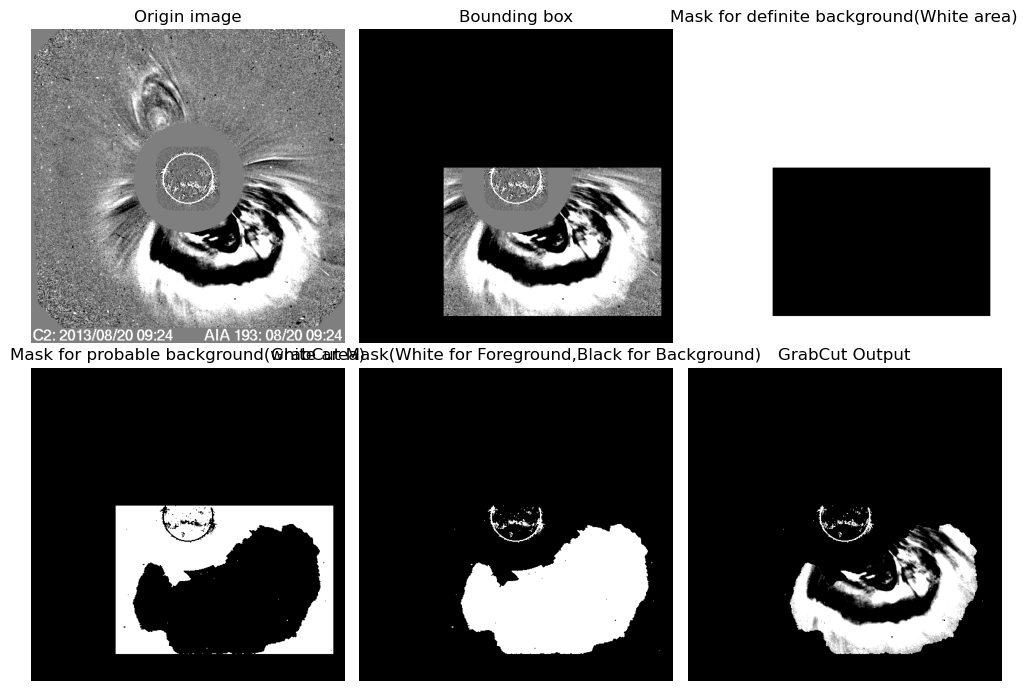

In [1]:
# 利用OpenCV实现GrabCut算法(前景选框)
# 来自https://blog.csdn.net/youcans/article/details/124744467
from PIL import Image
import cv2
import numpy as np
from matplotlib import pyplot as plt

image = cv2.imread("MiddleData/original/20130820_092405_lasc2rdf_aia193rdf.png", flags=1)  # 读取彩色图像(BGR)
mask = np.zeros(image.shape[:2], dtype="uint8")

# 定义矩形框，框选目标前景
# rect = (118, 125, 220, 245)  # 直接设置矩形的位置参数，也可以鼠标框选 ROI
print("Select a ROI and then press SPACE or ENTER button!\n")
roi = cv2.selectROI(image, showCrosshair=True, fromCenter=False)
xmin, ymin, w, h = roi  # 矩形裁剪区域 (ymin:ymin+h, xmin:xmin+w) 的位置参数
rect = (xmin, ymin, w, h)  # 边界框矩形的坐标和尺寸
imgROI = np.zeros_like(image)  # 创建与 image 相同形状的黑色图像
imgROI[ymin:ymin + h, xmin:xmin + w] = image[ymin:ymin + h, xmin:xmin + w].copy()
print(xmin, ymin, w, h)

fgModel = np.zeros((1, 65), dtype="float")  # 前景模型, 13*5
bgModel = np.zeros((1, 65), dtype="float")  # 背景模型, 13*5
iter = 5
(mask, bgModel, fgModel) = cv2.grabCut(image, mask, rect, bgModel, fgModel, iter,
                                        mode=cv2.GC_INIT_WITH_RECT)  # 框选前景分割模式

# 将所有确定背景和可能背景像素设置为 0，而确定前景和可能前景像素设置为 1
maskOutput = np.where((mask == cv2.GC_BGD) | (mask == cv2.GC_PR_BGD), 0, 1)
maskGrabCut = (maskOutput * 255).astype("uint8")
imgGrabCut = cv2.bitwise_and(image, image, mask=maskGrabCut)

plt.figure(figsize=(10, 7))
plt.subplot(231), plt.axis('off'), plt.title("Origin image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))                           # 显示 img(RGB)
plt.subplot(232), plt.axis('off'), plt.title("Bounding box")
plt.imshow(cv2.cvtColor(imgROI, cv2.COLOR_BGR2RGB))                          # 显示 img(RGB)
plt.subplot(233), plt.axis('off'), plt.title("Mask for definite background(White area)")
maskBGD = (mask == cv2.GC_BGD).astype("uint8") * 255
plt.imshow(maskBGD, 'gray')                                                  # definite background
plt.subplot(234), plt.axis('off'), plt.title("Mask for probable background(white area)")
maskPBGD = (mask == cv2.GC_PR_BGD).astype("uint8") * 255
plt.imshow(maskPBGD, 'gray')                                                 # probable background
plt.subplot(235), plt.axis('off'), plt.title("GrabCut Mask(White for Foreground,Black for Background)")
# maskGrabCut = np.where((mask==cv2.GC_BGD) | (mask==cv2.GC_PR_BGD), 0, 1)
plt.imshow(maskGrabCut, 'gray')                                              # mask generated by GrabCut
plt.subplot(236), plt.axis('off'), plt.title("GrabCut Output")
plt.imshow(cv2.cvtColor(imgGrabCut, cv2.COLOR_BGR2RGB))                      # GrabCut Output
plt.tight_layout()
plt.show()

使用掩膜图像的GrabCut算法

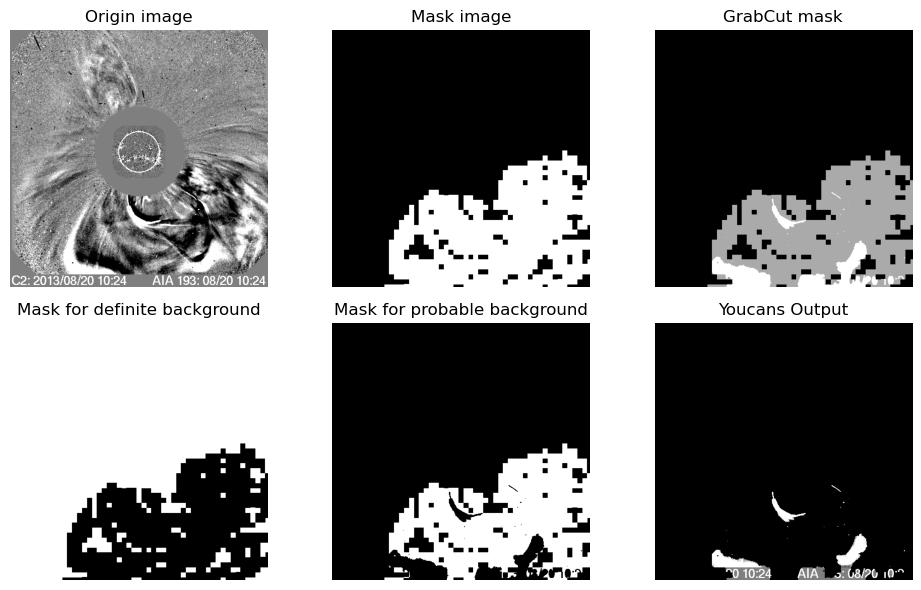

In [ ]:
# 利用OpenCV实现GrabCut算法（掩模图像）
# 来自https://blog.csdn.net/youcans/article/details/124744517
from PIL import Image
import cv2
import numpy as np
from matplotlib import pyplot as plt
# cv::GrabCutClasses {
#   cv::GC_BGD = 0,
#   cv::GC_FGD = 1,
#   cv::GC_PR_BGD = 2,
#   cv::GC_PR_FGD = 3
# }
image = cv2.imread("MiddleData/original/20130820_102405_lasc2rdf_aia193rdf.png", flags=1)  # 读取彩色图像(BGR)
# *对于CME灰度图像，三个通道的值完全相同
maskImg = cv2.imread("/home/lin/code/CMEclassfication/MiddleData/cropresult/crop9.png", flags=0)[:,512:]   # 读取掩模图像(xupt) TODO need modification

# 生成掩模图像 mask，大于 0 的像素设为可能前景
mask = np.zeros(image.shape[:2], dtype="uint8")
mask[maskImg > 0] = cv2.GC_PR_FGD
mask[maskImg == 0] = cv2.GC_BGD
# print(mask.shape, maskInv.shape)
# apply GrabCut using the the mask segmentation method
fgModel = np.zeros((1, 65), dtype="float")  # 前景模型, 13*5
bgModel = np.zeros((1, 65), dtype="float")  # 背景模型, 13*5
iter = 5
(mask, bgModel, fgModel) = cv2.grabCut(image, mask, None, bgModel, fgModel, iter,
                                        mode=cv2.GC_INIT_WITH_MASK)  # 基于掩模图像初始化

# 将所有确定背景和可能背景像素设置为 0，而确定前景和可能前景像素设置为 1
maskOutput = np.where((mask == cv2.GC_BGD) | (mask == cv2.GC_PR_BGD), 0, 1)
# //原为maskGrabCut = 255 - (maskOutput * 255).astype("uint8")，但其中不应为255减去
# //否则显示的区域就成了背景，所以进行修改
maskGrabCut = (maskOutput * 255).astype("uint8")
imgGrabCut = cv2.bitwise_and(image, image, mask=maskGrabCut)

plt.figure(figsize=(10, 6))
plt.subplot(231), plt.axis('off'), plt.title("Origin image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # 显示 img(RGB)
plt.subplot(232), plt.axis('off'), plt.title("Mask image")
plt.imshow(maskImg, 'gray')  # definite background
plt.subplot(233), plt.axis('off'), plt.title("GrabCut mask")
plt.imshow(mask, 'gray')
plt.subplot(234), plt.axis('off'), plt.title("Mask for definite background")
maskBGD = (mask == cv2.GC_BGD).astype("uint8") * 255
plt.imshow(maskBGD, 'gray')  # definite background
plt.subplot(235), plt.axis('off'), plt.title("Mask for probable background")
maskPBGD = (mask == cv2.GC_PR_BGD).astype("uint8") * 255
plt.imshow(maskPBGD, 'gray')  # probable background
# plt.subplot(235), plt.axis('off'), plt.title("GrabCut Mask")
# plt.imshow(maskGrabCut, 'gray')  # mask generated by GrabCut
plt.subplot(236), plt.axis('off'), plt.title("Youcans Output")
plt.imshow(cv2.cvtColor(imgGrabCut, cv2.COLOR_BGR2RGB))  # GrabCut Output
plt.tight_layout()
plt.show()



对掩膜图像的GrabCut进行了自行修改

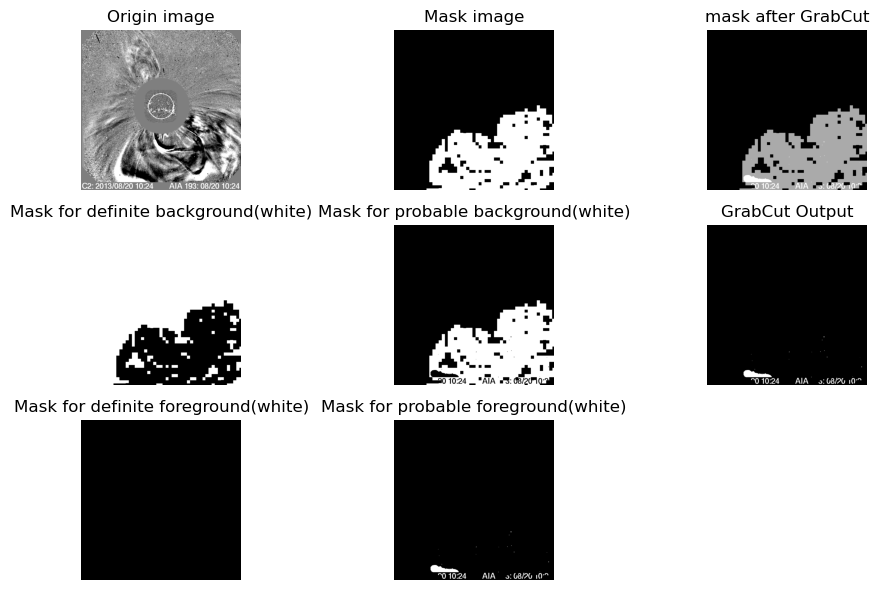

In [1]:
from PIL import Image
import cv2
import numpy as np
from matplotlib import pyplot as plt
# cv::GrabCutClasses {
#   cv::GC_BGD = 0,
#   cv::GC_FGD = 1,
#   cv::GC_PR_BGD = 2,
#   cv::GC_PR_FGD = 3
# }
image = cv2.imread("MiddleData/original/20130820_102405_lasc2rdf_aia193rdf.png", flags=1)  # 读取彩色图像(BGR)
# *对于CME灰度图像，三个通道的值完全相同
maskImg = cv2.imread("/home/lin/code/CMEclassfication/MiddleData/cropresult/crop9.png", flags=0)[:,512:]   # 读取掩模图像(xupt) TODO need modification

# 生成掩模图像 mask，大于 0 的像素设为可能前景
mask = np.zeros(image.shape[:2], dtype="uint8")
mask[maskImg > 0] = cv2.GC_PR_FGD
mask[maskImg == 0] = cv2.GC_BGD
# print(mask.shape, maskInv.shape)
# apply GrabCut using the the mask segmentation method
fgModel = np.zeros((1, 65), dtype="float")  # 前景模型, 13*5
bgModel = np.zeros((1, 65), dtype="float")  # 背景模型, 13*5
iter = 5
(maskAfter, bgModel, fgModel) = cv2.grabCut(image, mask, None, bgModel, fgModel, iter,
                                        mode=cv2.GC_INIT_WITH_MASK)  # 基于掩模图像初始化

# 将所有确定背景和可能背景像素设置为 0，而确定前景和可能前景像素设置为 1
maskOutput = np.where((maskAfter == cv2.GC_BGD) | (maskAfter == cv2.GC_PR_BGD), 0, 1)
# *原为maskGrabCut = 255 - (maskOutput * 255).astype("uint8")，但其中不应为255减去
# *否则显示的区域就成了背景，所以进行修改
maskGrabCut = (maskOutput * 255).astype("uint8")
imgGrabCut = cv2.bitwise_and(image, image, mask=maskGrabCut)

plt.figure(figsize=(10, 6))
plt.subplot(331), plt.axis('off'), plt.title("Origin image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # 显示 img(RGB)

plt.subplot(332), plt.axis('off'), plt.title("Mask image")
plt.imshow(maskImg, 'gray')  # definite background

plt.subplot(333), plt.axis('off'), plt.title("mask after GrabCut")
plt.imshow(maskAfter, 'gray')

plt.subplot(334), plt.axis('off'), plt.title("Mask for definite background(white)")
maskBGD = (maskAfter == cv2.GC_BGD).astype("uint8") * 255
plt.imshow(maskBGD, 'gray')  # definite background

plt.subplot(335), plt.axis('off'), plt.title("Mask for probable background(white)")
maskPBGD = (maskAfter == cv2.GC_PR_BGD).astype("uint8") * 255
plt.imshow(maskPBGD, 'gray')  # probable background

# plt.subplot(235), plt.axis('off'), plt.title("GrabCut Mask")
# plt.imshow(maskGrabCut, 'gray')  # mask generated by GrabCut
plt.subplot(336), plt.axis('off'), plt.title("GrabCut Output")
plt.imshow(cv2.cvtColor(imgGrabCut, cv2.COLOR_BGR2RGB))  # GrabCut Output

plt.subplot(337), plt.axis('off'), plt.title("Mask for definite foreground(white)")
maskFGD = (maskAfter == cv2.GC_FGD).astype("uint8") * 255
plt.imshow(maskFGD, 'gray')  # definite foreground

plt.subplot(338), plt.axis('off'), plt.title("Mask for probable foreground(white)")
maskPBFD = (maskAfter == cv2.GC_PR_FGD).astype("uint8") * 255
plt.imshow(maskPBFD, 'gray')  # probable foreground

plt.tight_layout()
plt.show()
#原图 掩膜图 grabcut生成的mask 前景 背景 绝对前景 绝对背景 grabcut后的图

掩膜图像的GrabCut方法封装

In [2]:
from PIL import Image
import cv2
import numpy as np
from matplotlib import pyplot as plt


def cutWithMask(image: np.ndarray, maskImg: np.ndarray) -> np.ndarray:
    '''对image进行GrabCut，使用maskImg作为掩膜

    Parameters
    ----------
    image : np.ndarray
        需要进行GrabCut的图像，为BGR图像，形状为NHWC
    maskImg : np.ndarray
        作为掩膜的图像，为灰度图，形状为NHW
    Returns
    ----------
    maskAfter : np.ndarray
        经过GrabCut处理过后的掩膜，该数组的值为[0,1,2,3]其中之一，其定义为
        cv::GC_BGD = 0,
        cv::GC_FGD = 1,
        cv::GC_PR_BGD = 2,
        cv::GC_PR_FGD = 3
    '''
    #image = cv2.imread(imagePath, flags=1)  # 读取彩色图像(BGR)
    # *CV2中，图片默认为BGR格式
    for i in range(image.shape[0]):
        image[i] = cv2.cvtColor(image[i], cv2.COLOR_RGB2BGR)

    # 对于CME灰度图像，三个通道的值完全相同
    #maskImg = cv2.imread(maskImgPath, flags=0)[:, 512:]  # 读取掩模图像(xupt)

    # 生成掩模图像 mask，大于 0 的像素设为可能前景
    mask = np.zeros(image.shape[:3], dtype="uint8")
    mask[maskImg > 0] = cv2.GC_PR_FGD
    mask[maskImg == 0] = cv2.GC_BGD
    # print(mask.shape, maskInv.shape)
    # apply GrabCut using the the mask segmentation method
    fgModel = np.zeros((image.shape[0], 1, 65), dtype="float")  # 前景模型, 13*5
    bgModel = np.zeros((image.shape[0], 1, 65), dtype="float")  # 背景模型, 13*5
    iter = 5
    maskAfter = np.zeros(image.shape[:3], dtype="uint8")
    for i in range(image.shape[0]):
        (maskAfter[i], bgModel[i],
         fgModel[i]) = cv2.grabCut(image[i],
                                   mask[i],
                                   None,
                                   bgModel[i],
                                   fgModel[i],
                                   iter,
                                   mode=cv2.GC_INIT_WITH_MASK)  # 基于掩模图像初始化
    return maskAfter


def showGrabCutWithMask(image: np.ndarray, maskImg: np.ndarray,
                        maskAfter: np.ndarray):
    '''绘制GrabCut的结果

    Parameters
    ----------
    image : np.ndarray
        经GrabCut处理之前的原图像，形状为HWC
    maskImg : np.ndarray
        掩膜图像，形状为HW
    maskAfter : np.ndarray
        经过GrabCut处理之后的mask，形状为HW
    '''
    # 将所有确定背景和可能背景像素设置为 0，而确定前景和可能前景像素设置为 1
    maskOutput = np.where(
        (maskAfter == cv2.GC_BGD) | (maskAfter == cv2.GC_PR_BGD), 0, 1)
    # *原为maskGrabCut = 255 - (maskOutput * 255).astype("uint8")，但其中不应为255减去
    # *否则显示的区域就成了背景，所以进行修改
    maskGrabCut = (maskOutput * 255).astype("uint8")
    imgGrabCut = cv2.bitwise_and(image, image,
                                 mask=maskGrabCut).astype('uint8')

    plt.figure(figsize=(13, 6))
    plt.subplot(331), plt.axis('off'), plt.title("Origin image")
    plt.imshow(cv2.cvtColor(image.astype('uint8'),
                            cv2.COLOR_BGR2RGB))  # 显示 img(RGB)

    plt.subplot(332), plt.axis('off'), plt.title("Mask image")
    plt.imshow(maskImg, 'gray')  # definite background

    plt.subplot(333), plt.axis('off'), plt.title("GrabCut Output")
    plt.imshow(cv2.cvtColor(imgGrabCut, cv2.COLOR_BGR2RGB))  # GrabCut Output

    plt.subplot(334), plt.axis('off'), plt.title("mask after GrabCut")
    plt.imshow(maskAfter, 'gray')

    plt.subplot(335), plt.axis('off'), plt.title(
        "Mask for definite background(white)")
    maskBGD = (maskAfter == cv2.GC_BGD).astype("uint8") * 255
    plt.imshow(maskBGD, 'gray')  # definite background

    plt.subplot(336), plt.axis('off'), plt.title(
        "Mask for probable background(white)")
    maskPBGD = (maskAfter == cv2.GC_PR_BGD).astype("uint8") * 255
    plt.imshow(maskPBGD, 'gray')  # probable background

    # plt.subplot(235), plt.axis('off'), plt.title("GrabCut Mask")
    # plt.imshow(maskGrabCut, 'gray')  # mask generated by GrabCut

    plt.subplot(337), plt.axis('off'), plt.title(
        "Mask for definite foreground(white)")
    maskFGD = (maskAfter == cv2.GC_FGD).astype("uint8") * 255
    plt.imshow(maskFGD, 'gray')  # definite foreground

    plt.subplot(338), plt.axis('off'), plt.title(
        "Mask for probable foreground(white)")
    maskPBFD = (maskAfter == cv2.GC_PR_FGD).astype("uint8") * 255
    plt.imshow(maskPBFD, 'gray')  # probable foreground

    plt.tight_layout()
    plt.show()


前景选框的GrabCut方法封装

In [3]:
def cutWithROI(image: np.ndarray) -> tuple:
    '''对image进行GrabCut，采用框选的方式选择前景

    Parameters
    ----------
    image : np.ndarray
        待分割的图像数组，形状为NHWC

    Returns
    -------
    maskAfter : np.ndarray
        经过GrabCut处理过后的掩膜，该数组的值为[0,1,2,3]其中之一，其定义为
        cv::GC_BGD = 0,
        cv::GC_FGD = 1,
        cv::GC_PR_BGD = 2,
        cv::GC_PR_FGD = 3
    '''
    # *CV2中，图片默认为BGR格式
    picNums = image.shape[0]
    for i in range(image.shape[0]):
        image[i] = cv2.cvtColor(image[i], cv2.COLOR_RGB2BGR)
    mask = np.zeros(image.shape[:3], dtype="uint8")

    # 定义矩形框，框选目标前景
    # rect = (118, 125, 220, 245)  # 直接设置矩形的位置参数，也可以鼠标框选 ROI
    rois = []
    # imgsROI = np.zeros_like(image)  # 创建与 image 相同形状的黑色图像，方便展示选框框住的物体
    for i in range(picNums):
        windowName = 'Selecting ROI {}/{}'.format(i, picNums)
        roi = cv2.selectROI(windowName,
                            image[i],
                            showCrosshair=True,
                            fromCenter=False)
        rois.append(roi)
        # xmin, ymin, w, h = roi
        # imgsROI[i, ymin:ymin + h, xmin:xmin + w] = image[i, ymin:ymin + h,
        #                                                  xmin:xmin + w].copy()

    fgModel = np.zeros((picNums, 1, 65), dtype="float")  # 前景模型, 13*5
    bgModel = np.zeros((picNums, 1, 65), dtype="float")  # 背景模型, 13*5
    iter = 5
    maskAfter = np.zeros(image.shape[:3], dtype="uint8")
    for i in range(picNums):
        (maskAfter[i], bgModel[i],
         fgModel[i]) = cv2.grabCut(image[i],
                                   mask[i],
                                   rois[i],
                                   bgModel[i],
                                   fgModel[i],
                                   iter,
                                   mode=cv2.GC_INIT_WITH_RECT)  # 框选前景分割模式
    return maskAfter, rois


def showGrabCutWithROI(image: np.ndarray, roi: tuple, maskAfter: np.ndarray):
    '''绘制利用ROI框选前景的GrabCut结果

    Parameters
    ----------
    image : np.ndarray
        待分割的原图片数组,形状为HW
    rois : list
        图片选框的四元组，包含xmin,ymin,w,h
    maskAfter : np.ndarray
        GrabCut输出的mask
    '''
    # 将所有确定背景和可能背景像素设置为 0，而确定前景和可能前景像素设置为 1
    maskOutput = np.where(
        (maskAfter == cv2.GC_BGD) | (maskAfter == cv2.GC_PR_BGD), 0, 1)
    # *原为maskGrabCut = 255 - (maskOutput * 255).astype("uint8")，但其中不应为255减去
    # *否则显示的区域就成了背景，所以进行修改
    maskGrabCut = (maskOutput * 255).astype("uint8")
    imgGrabCut = cv2.bitwise_and(image, image,
                                 mask=maskGrabCut).astype('uint8')

    plt.figure(figsize=(13, 6))
    plt.subplot(331), plt.axis('off'), plt.title("Origin image")
    plt.imshow(cv2.cvtColor(image.astype('uint8'),
                            cv2.COLOR_BGR2RGB))  # 显示 img(RGB)

    imgROI = np.zeros_like(image)
    xmin, ymin, w, h = roi
    imgROI[ymin:ymin + h, xmin:xmin + w] = image[ymin:ymin + h,
                                                     xmin:xmin + w].copy()
    plt.subplot(332), plt.axis('off'), plt.title("Bounding Box")
    plt.imshow(imgROI, 'gray')  # definite background

    plt.subplot(333), plt.axis('off'), plt.title("GrabCut Output")
    plt.imshow(cv2.cvtColor(imgGrabCut, cv2.COLOR_BGR2RGB))  # GrabCut Output

    plt.subplot(334), plt.axis('off'), plt.title("mask after GrabCut")
    plt.imshow(maskAfter, 'gray')

    plt.subplot(335), plt.axis('off'), plt.title(
        "Mask for definite background(white)")
    maskBGD = (maskAfter == cv2.GC_BGD).astype("uint8") * 255
    plt.imshow(maskBGD, 'gray')  # definite background

    plt.subplot(336), plt.axis('off'), plt.title(
        "Mask for probable background(white)")
    maskPBGD = (maskAfter == cv2.GC_PR_BGD).astype("uint8") * 255
    plt.imshow(maskPBGD, 'gray')  # probable background

    # plt.subplot(235), plt.axis('off'), plt.title("GrabCut Mask")
    # plt.imshow(maskGrabCut, 'gray')  # mask generated by GrabCut

    plt.subplot(337), plt.axis('off'), plt.title(
        "Mask for definite foreground(white)")
    maskFGD = (maskAfter == cv2.GC_FGD).astype("uint8") * 255
    plt.imshow(maskFGD, 'gray')  # definite foreground

    plt.subplot(338), plt.axis('off'), plt.title(
        "Mask for probable foreground(white)")
    maskPBFD = (maskAfter == cv2.GC_PR_FGD).astype("uint8") * 255
    plt.imshow(maskPBFD, 'gray')  # probable foreground

    plt.tight_layout()
    plt.show()


# GrabCut算法测试

测试一 20140106_1

In [4]:
import model.model_defination
import utils
import DDT

net = model.model_defination.LeNet5()
parameter_path = 'log/2022_04_13_20_00_25/parameters.pkl'
net.load_param(parameter_path)
cropnet = model.model_defination.LeNet5()
parameter_path = 'log/2022_06_22_17_59_11/parameters.pkl'
cropnet.load_param(parameter_path)
crop = utils.CenterCrop()


/home/lin/anaconda3/envs/graph/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
PathCME20140106_1 = 'CME_data/20140106_1'
imageArray20140106_1 = utils.loadImageFolder(PathCME20140106_1)
cropimageArray20140106_1 = crop(imageArray20140106_1)
cropnet.predict(cropimageArray20140106_1)
cropimageArray20140106_1 = cropimageArray20140106_1[cropnet.predict(
    cropimageArray20140106_1) == 1]
largestComp20140106_1 = DDT.DDT(cropimageArray20140106_1, cropnet)


Processing pic 1/15
Processing pic 2/15
Processing pic 3/15
Processing pic 4/15
Processing pic 5/15
Processing pic 6/15
Processing pic 7/15
Processing pic 8/15
Processing pic 9/15
Processing pic 10/15
Processing pic 11/15
Processing pic 12/15
Processing pic 13/15
Processing pic 14/15
Processing pic 15/15


In [6]:
cropimageArray20140106_1 = cropimageArray20140106_1.squeeze()
stackcropimageArray20140106_1 = utils.grayImageToRGB(
    cropimageArray20140106_1).astype('uint8')
#!最大连接分量存在翻转情况
reverlargestComp20140106_1 = 1 - largestComp20140106_1
# *CutWithMask所接受的Image图片必须为uint8类型
maskafter = cutWithMask(stackcropimageArray20140106_1,
                        reverlargestComp20140106_1)


In [12]:
maskafterROI, rois = cutWithROI(stackcropimageArray20140106_1)


Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!


QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to tar

Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!


QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to tar

Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!


QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to tar

Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!


QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to tar

Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!


QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to tar

Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!


QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to tar

Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!


QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to tar

Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!


QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to tar

Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!


QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to tar

Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!


QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to tar

Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!


QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to tar

Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!


QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to tar

Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!


QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to tar

Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!


QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to tar

Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!


QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to target thread (0x5573c79cfa50)

QObject::moveToThread: Current thread (0x5573c79cfa50) is not the object's thread (0x5573ca5a53c0).
Cannot move to tar

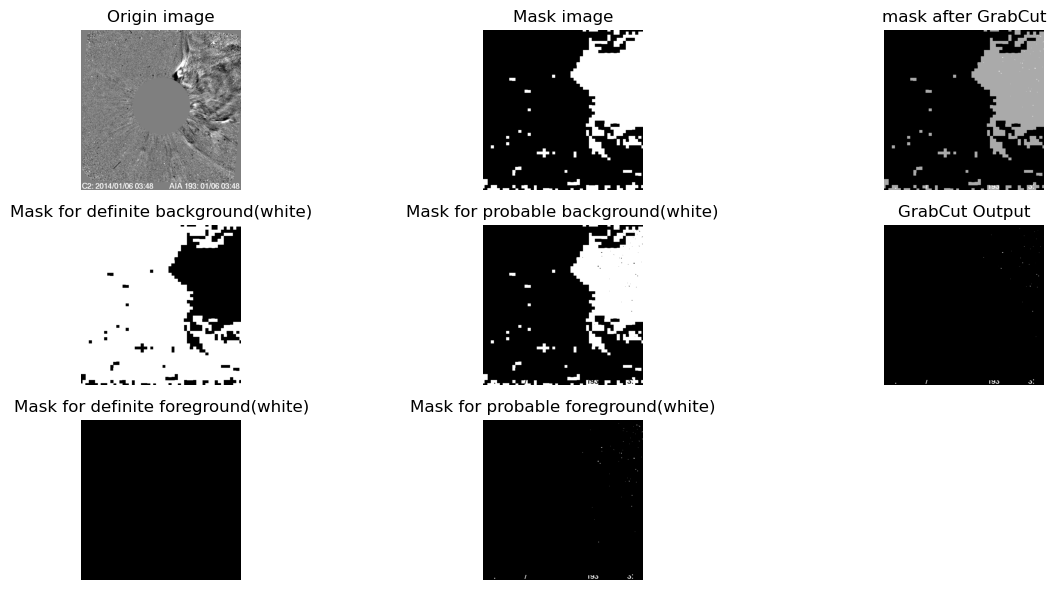

In [10]:
picIndex = 1
showGrabCutWithMask(cropimageArray20140106_1[picIndex],
            reverlargestComp20140106_1[picIndex], maskafter[picIndex])


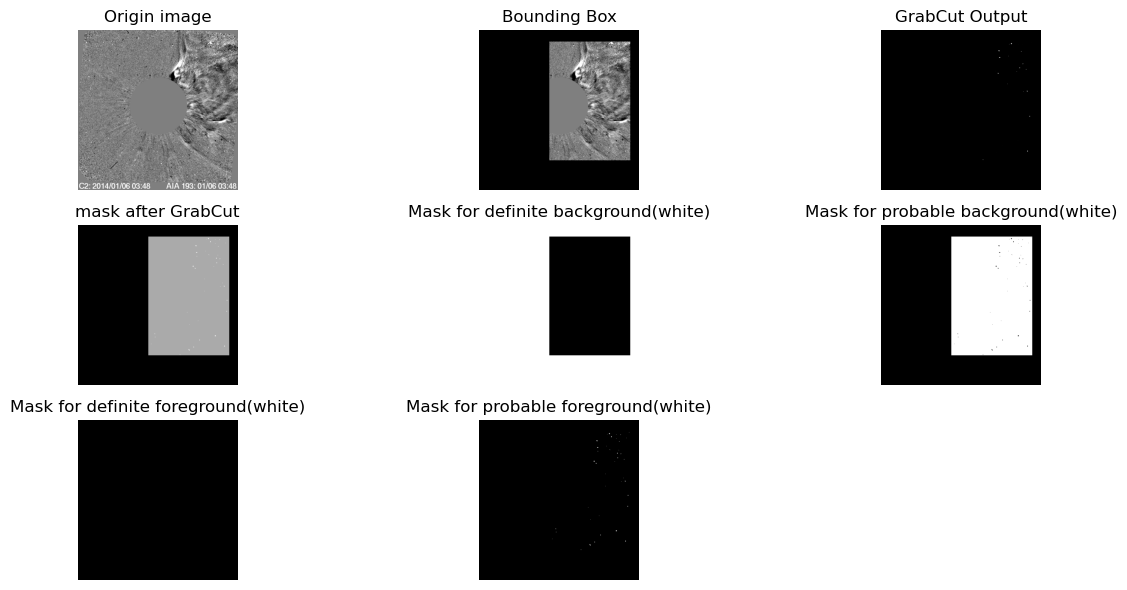

In [13]:
picIndex = 1
showGrabCutWithROI(cropimageArray20140106_1[picIndex],rois[picIndex],maskafterROI[picIndex])